<a href="https://colab.research.google.com/github/cyndwith/DeepGC/blob/master/SRCNN/mySRCNN_9_5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteFNTPM0/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteFNTPM0/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteFNTPM0/oxford_flowers102-validation.tfrecord



Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.0.0,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).
',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Imag

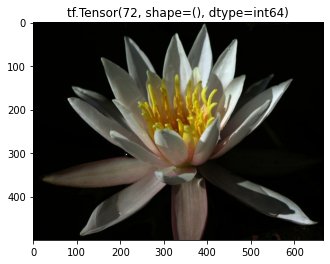

In [0]:
splits = ("train[:80]", "train[:10]", "train[:10]")
#splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'oxford_flowers102', split=splits,
    with_info=True, as_supervised=True)

print(metadata)
print(raw_train)
print(raw_validation)
print(raw_test)

get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>


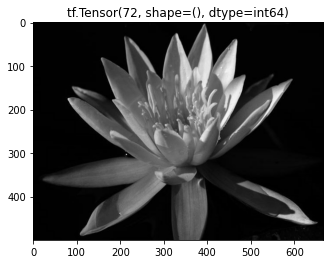

In [0]:
def resize_dataset(image, label):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, tf.float32)
  image = (image/255)
  #image = tf.image.resize(image, (128, 128))
  return image, label 

# Apply this function to each item in the dataset using the map method:
flower_train      = raw_train.map(resize_dataset)
flower_validation = raw_validation.map(resize_dataset)
flower_test       = raw_test.map(resize_dataset)
print(flower_train)
print(flower_validation)
print(flower_test)

for image, label in flower_train.take(1):
  plt.figure()
  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.title(get_label_name(label))

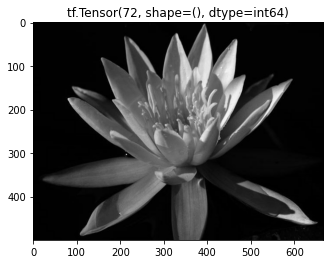

In [0]:
# Format the Data
SCALE = 3
STRIDE = 14
IMG_SIZE = 33 # All images will be divided into 33x33 patch
LABEL_SIZE = 21
def format_dataset(dataset):
  count = 0
  sub_input_sequence = []
  sub_label_sequence = []
  for image, label in dataset:
    #print('image.shape', image.shape)
    if (len(image.shape) == 3):
      image = tf.expand_dims(image, axis=0)
    #print('image.shape', image.shape)
    _, h, w, _ = image.shape
    #print('before (h,w):', h, w)
    h = h - np.mod(h, SCALE)
    w = w - np.mod(w, SCALE)
    #print('after (h,w"):', h, w)

    image = np.array(image).astype(np.float)
    label = image[:, 0:h, 0:w, :]
    #print('label:', label.shape)
    
    image = image / 255.
    label = label / 255.

    down_size = (int(h/SCALE), int(w/SCALE))
    up_size = (h, w)
    
    input_resize = tf.image.resize(label, down_size)
    input_resize = tf.image.resize(input_resize, up_size)
    #print('image (h,w):', h, w)    
    #print('input_resize:', input_resize.shape)
    #print('label:', label.shape)
    pad = abs(IMG_SIZE - LABEL_SIZE) / 2
    for y in range(0, h - IMG_SIZE+1, STRIDE):
      for x in range(0, w - IMG_SIZE+1, STRIDE):
        sub_input = input_resize[:, y:y+IMG_SIZE, x:x+IMG_SIZE, :]
        sub_label = label[:, y+int(pad):y+int(pad)+LABEL_SIZE, x+int(pad):x+int(pad)+LABEL_SIZE, :]
        
        #print('label.shape, pad, h, w, x, y:', label.shape, pad, h, w, x, y)
        #print('sub_input:', sub_input.shape)
        #print('sub_label:', sub_label.shape)

        sub_input = tf.reshape(sub_input, [-1, IMG_SIZE, IMG_SIZE, 1])
        sub_label = tf.reshape(sub_label, [-1, LABEL_SIZE, LABEL_SIZE, 1])
        
        sub_input_sequence.append(sub_input)
        sub_label_sequence.append(sub_label)
        # print("x, y:", x, y)
    count += 1
    print("image count:", count)      
    # if (count == 50):
    #   break

  # sub_input_sequence = np.asarray(sub_input_sequence).astype(np.float32)
  # sub_label_sequence = np.asarray(sub_label_sequence).astype(np.float32)

  dataset = tf.data.Dataset.from_tensor_slices((sub_input_sequence, sub_label_sequence))
  # return sub_input_sequence, sub_label_sequence
  return dataset

for image, label in flower_train.take(1):
  plt.figure()
  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.title(get_label_name(label))

# Now shuffle and batch the data.
#BATCH_SIZE = 128
#SHUFFLE_BUFFER_SIZE = 1000

#flower_train_batches      = flower_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=False)
#flower_validation_batches = flower_validation.batch(BATCH_SIZE, drop_remainder=False)
#flower_test_batches       = flower_test.batch(BATCH_SIZE, drop_remainder=False)

#print(flower_train_batches)
#print(flower_validation_batches)
#print(flower_test_batches)

In [0]:
flower_train_data      = format_dataset(flower_train)
print(flower_train_data)

for image, label in flower_train_data.take(1):
  plt.figure()
  plt.imshow(tf.squeeze(image[1, :, :, :]), cmap='gray')
  plt.title('sub image')
  plt.figure()
  plt.imshow(tf.squeeze(label[1, :, :, :]), cmap='gray')
  plt.title('sub label')
  
# print(flower_train_data[0].shape)
# print(flower_train_data[1].shape)

In [0]:
# flower_validation_data = format_dataset(flower_validation)
# print(flower_validation_data)

In [0]:
# flower_test_data      = format_dataset(flower_test)
# print(flower_test_data)

In [0]:
# Now shuffle and batch the data.
'''
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

flower_train_batches      = flower_train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
flower_validation_batches = flower_validation_data.batch(BATCH_SIZE)
flower_test_batches       = flower_test_data.batch(BATCH_SIZE)

print(flower_train_batches)
print(flower_validation_batches)
print(flower_test_batches)
'''

'\nBATCH_SIZE = 64\nSHUFFLE_BUFFER_SIZE = 1000\n\nflower_train_batches      = flower_train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)\nflower_validation_batches = flower_validation_data.batch(BATCH_SIZE)\nflower_test_batches       = flower_test_data.batch(BATCH_SIZE)\n\nprint(flower_train_batches)\nprint(flower_validation_batches)\nprint(flower_test_batches)\n'

In [0]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  print('h, w:', h, w)
  out_h = (size[0] - 1) * LABEL_IMAGE + h
  out_w = (size[1] - 1) * LABEL_IMAGE + w
  #img = np.zeros((h*size[0], w*size[1], 1))
  img = np.zeros((out_h, out_w, 1))
  print('img.shape', img.shape)
  # print('image shape', images.shape)
  # print('size:', size[0], size[1])
  for idx, image in enumerate(images):
    # print('idx:', idx)
    # print('image shape', image.shape)
    i = idx % size[1]
    j = idx // size[1]
    # print('i, j:', i, j)
    #img[j*h:j*h+h, i*w:i*w+w, :] = image
    img[j*LABEL_IMAGE:j*LABEL_IMAGE+h, i*LABEL_IMAGE:i*LABEL_IMAGE+w, :] = image


  return img

def test(model, image):
  print('image:', image.shape)
  #_, h, w, _ = image.shape
  h = w = 128
  nx = ny = 0 
  sub_input = []
  for x in range(0, h - IMG_SIZE+1, LABEL_IMAGE):
    nx += 1; ny = 0
    for y in range(0, w - IMG_SIZE+1, LABEL_IMAGE):
      ny += 1
      sub_input_patch = image[x:x+IMG_SIZE, y:y+IMG_SIZE, :]    
      sub_input_patch = tf.reshape(sub_input_patch, [IMG_SIZE, IMG_SIZE, 1])
      sub_input.append(sub_input_patch)
  sub_input = np.asarray(sub_input)
  print('sub input shape:', sub_input.shape)
  print('nx,ny:', nx, ny)
  pred = model(sub_input)
  # print('pred shape', pred.shape)
  output = merge(pred, [nx, ny])
  return output

def SRCNN955(input_shape):
  n0 = tf.keras.layers.Input(input_shape)
  # conv2d
  n = tf.keras.layers.Conv2D(64, kernel_size=(9, 9), strides=1, padding='valid')(n0)
  n = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1, padding='same')(n)
  n = tf.keras.layers.Conv2D(1, kernel_size=(5, 5), strides= 1, padding='valid')(n)

  model = tf.keras.Model(inputs=n0, outputs=n, name='srcnn955')
  model.summary()
  return model

input_shape = (IMG_SIZE, IMG_SIZE, 1)
srcnn_model = SRCNN955(input_shape)


In [0]:
import os
import time
from IPython.display import clear_output

def model_loss(pred, ref):
  pred = tf.cast(pred, dtype = tf.float32)
  ref = tf.cast(ref, dtype=tf.float32)
  loss = tf.reduce_mean(tf.square(tf.subtract(pred, ref)))
  return loss

model_optimizer = tf.keras.optimizers.Adam(1e-4)

srcnn_model.compile(optimizer=model_optimizer,
              loss=model_loss,
              metrics=['mse'])

# inception_resnet_v1_model = InceptionResNetV1()
checkpoint_dir = '/content/srcnn_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=model_optimizer,
                                 model=srcnn_model)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(image, ref):
    with tf.GradientTape() as grad_tape:
      '''
      if os.path.isdir(checkpoint_dir):
        print('load from checkpoint')
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        latest 
        input_shape = (IMG_SIZE, IMG_SIZE, 1)
        srcnn_model = SRCNN955(input_shape)
        srcnn_model.load_weights(latest)
      elif os.path.isdir("/content/srcnn_model"):
        print('load saved model')
        srcnn_model = tf.keras.models.load_model('/content/srcnn_model')
      else:
        print('fresh model')
        input_shape = (IMG_SIZE, IMG_SIZE, 1)
        srcnn_model = SRCNN955(input_shape)
      '''
      pred = srcnn_model(image)
      loss = model_loss(pred, ref)
    gradients_of_model = grad_tape.gradient(loss, srcnn_model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_of_model, srcnn_model.trainable_variables))
    print('Training Loss: {}'.format(loss))
    return loss

'''
# before training
for image, label in flower_train:
  plt.figure()
  plt.imshow(image)
  image = tf.expand_dims(image, 0)
  print(image.shape)
  input_image = flower_train_data[0]
  output = test(srcnn_model, input_image)
  plt.figure()
  plt.imshow(output)
  break
'''
model_save_path = '/content/srcnn_model/'
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    # print('len(dataset[0]:)', len(dataset[0]))
    for image, label in dataset:
      # image = tf.expand_dims(image, 0)
      # label = tf.expand_dims(label, 0)
      loss = train_step(image, label)
      # print('train step:', n)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      srcnn_model.save(model_save_path)
      checkpoint.save(file_prefix = checkpoint_prefix)
      # test after one epoch
      for image, label in flower_train.take(1):
        # print('test image:', image.shape)
        # print('test label:', label.shape)
        output = test(srcnn_model, image)
        output = tf.squeeze(output)
        clear_output()
        plt.figure(1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.figure(2) 
        plt.imshow(tf.squeeze(output), cmap='gray')
        plt.pause(0.1)

    print ('Training Loss {}, Time for epoch {} is {} sec'.format(loss, epoch + 1, time.time()-start))


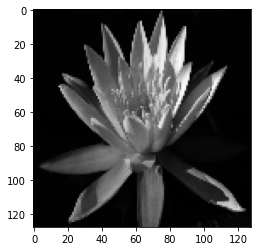

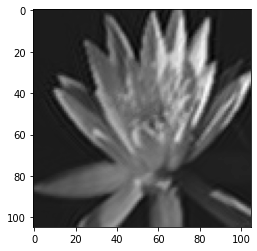

Training Loss 8.250360394868039e-08, Time for epoch 780 is 18.176756143569946 sec
Training Loss 8.25026802431239e-08, Time for epoch 781 is 0.24831080436706543 sec
Training Loss 8.250189154068721e-08, Time for epoch 782 is 0.19452691078186035 sec
Training Loss 8.250108152196844e-08, Time for epoch 783 is 0.1906442642211914 sec
Training Loss 8.250021465983082e-08, Time for epoch 784 is 0.18968844413757324 sec
Training Loss 8.249932648141112e-08, Time for epoch 785 is 0.189561128616333 sec
Training Loss 8.249841698670934e-08, Time for epoch 786 is 0.18513727188110352 sec
Training Loss 8.249755722999907e-08, Time for epoch 787 is 0.189072847366333 sec
Training Loss 8.249665484072466e-08, Time for epoch 788 is 0.1817469596862793 sec
Training Loss 8.249580218944175e-08, Time for epoch 789 is 0.1948845386505127 sec
INFO:tensorflow:Assets written to: /content/srcnn_model/assets


INFO:tensorflow:Assets written to: /content/srcnn_model/assets


image: (128, 128, 1)
sub input shape: (49, 33, 33, 1)
nx,ny: 7 7
h, w: 21 21
img.shape (105, 105, 1)


In [0]:
train(flower_train_data, 2000)

In [0]:
train(flower_train_data, 500)

In [0]:
train(flower_train_data, 1000)

In [0]:
# Learning curves
acc = model_history.history['mse']
val_acc = model_history.history['val_mse']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Evaluate the model

In [0]:
# Convert Keras model to TF Lite format.
print(tf.__version__)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

In [0]:
import random

test_images = test.batch(1)

def show_model_predictions(tflite_model, dataset=test_images, num=1):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_image = []
  # test after one epoch
  for image, label in flower_train.take(1):
    # print('test image:', image.shape)
    # print('test label:', label.shape)
    output = test(srcnn_model, image)
    output = tf.squeeze(output)
    clear_output()
    plt.figure(1)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.figure(2) 
    plt.imshow(tf.squeeze(output), cmap='gray')
    plt.pause(0.1)

  # Run predictions on every image in the "test" dataset.
  for test_image, test_label in flower_train_data.take(1):
    # Pre-processing: 
    interpreter.set_tensor(input_tensor_index, test_image)
    # Run inference.
    interpreter.invoke()
    # Post-processing: 
    prediction_image.append(output())
    output = merge(prediction_image, [7, 7])
    output = tf.squeeze(output)
    clear_output()
    plt.figure(1)
    plt.imshow(tf.squeeze(output), cmap='gray')
    plt.pause(0.1)   


# float model prediction
show_model_predictions(tflite_float_model)

# quantized model prediction
show_model_predictions(tflite_quantized_model)